#### This notebook tests the noise-corrected correlation formula on simulated crowding thresholds and reading speeds.
Created Jan 13, 2025  //  Last updated Mar 4, 2025

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, norm
import random
import matplotlib.colors as mcolors

In [3]:
random.seed(42)

Below is data Helen sent on Feb 3 to inform mean crowding threshold and learning factor.

In [4]:
# # latest crowding means by block (log bouma)
# crowding_thresh = np.array([-0.426, -0.489, -0.525, -0.537, -0.563, -0.568])
# crowding_thresh_changes = np.array([np.abs(crowding_thresh[1] - crowding_thresh[0]), 
#                                     np.abs(crowding_thresh[2] - crowding_thresh[1]),
#                                     np.abs(crowding_thresh[3] - crowding_thresh[2]),
#                                     np.abs(crowding_thresh[4] - crowding_thresh[3]),
#                                     np.abs(crowding_thresh[5] - crowding_thresh[4])])
# plt.plot(np.arange(1,6), crowding_thresh_changes)
# plt.xlabel('start block', size=14)
# plt.ylabel('absolute change in log bouma', size=14)
# plt.title('Helen\'s data', size=16)

## Functions for simulations

In [5]:
class def_variable_parameters:
    
    def __init__(self, betweenVar, withinVar, mean, learning_factor):
        self.ObsVar = betweenVar
        self.MeasVar = withinVar
        self.Mean = mean
        self.learning_factor = learning_factor

In [6]:
def simulate_psychophysics_data(crowding_params, rsvp_params, n_samples=100, n_measurements=6, correlation = -0.7):
    '''
    Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
    for specified number of samples and measurements per sample for each task
    
    Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
    and the mean of those measurements for each "participant" (sample)
    
    # Parameters for the simulation
    The two required inputs are two objects, 
    each containing the parameters of the x and the y components of this correlation simulation.
     '''

    # Covariance matrix for the "true" thresholds
    cov_matrix = np.array([
        [crowding_params.ObsVar, correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar)],
        [correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar), rsvp_params.ObsVar]
    ])

    # Simulate "true" thresholds for crowding and RSVP reading
    true_thresholds = np.random.multivariate_normal(
        mean=[crowding_params.Mean, rsvp_params.Mean],
        cov=cov_matrix,
        size=n_samples
    )

    # Extract "true" values for crowding and RSVP
    true_crowding = true_thresholds[:, 0]
    true_rsvp = true_thresholds[:, 1]

    # Initialize a dictionary to store measurements
    data = {
        'crowding_true': true_crowding,
        'rsvp_true': true_rsvp,
    }

    # Simulate noisy measurements for both tasks in a single loop
    # Account for learning in crowding task 
    crowding_measurements = []
    rsvp_measurements = []
    for i in range(n_measurements):
        crowding_noise = np.random.normal(0, np.sqrt(crowding_params.MeasVar), size=n_samples)
        rsvp_noise = np.random.normal(0, np.sqrt(rsvp_params.MeasVar), size=n_samples)
        
        # Calculate noisy measurements 
        crowding_measurement = true_crowding + crowding_noise
        rsvp_measurement = true_rsvp + rsvp_noise
        
        # Reduce crowding thresholds by learning factor
        if i > 0:
            crowding_measurement -= sum(crowding_params.learning_factor / j for j in range(1, i + 1))
            rsvp_measurement -= sum(rsvp_params.learning_factor / j for j in range(1, i + 1))

        # Add individual measurements to the dictionary
        data[f'crowding_measurement{i+1}'] = crowding_measurement
        data[f'rsvp_measurement{i+1}'] = rsvp_measurement

        # Collect measurements for later averaging
        crowding_measurements.append(crowding_measurement)
        rsvp_measurements.append(rsvp_measurement)

    # Compute the averages of all measurements
    data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
    data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

    # Create and return the DataFrame
    simulation_data = pd.DataFrame(data)
    return simulation_data

In [7]:
# test codes for updated function
# simulate_psychophysics_data(crowding_param, rsvp_param, n_samples=100, n_measurements=6, correlation = -0.7)


In [8]:
# simulation_data = simulate_psychophysics_data(n_samples=100, n_measurements=6)
# simulation_data = simulation_data[sorted(simulation_data.columns)]
# simulation_data.head()

In [9]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 10))
# # Scatter plot
# ax.scatter(x, y, alpha=0.7)

# # Regression line
# # UPDATE TO MINIMIZE PRODUCT OF X AND Y RESIDUALS
# slope, intercept = np.polyfit(x, y, 1)
# x_vals = np.linspace(min(x), max(x), 100)
# y_vals = slope * x_vals + intercept
# ax.plot(x_vals, y_vals, color='red', linestyle='dashed', label='Trend line')

# # Pearson correlation
# r, _ = stats.pearsonr(x, y)
# ax.text(0.05, 1.05, f'Pearson r = {r:.2f}', transform=ax.transAxes, fontsize=14, color='red')

# # Labels and title
# ax.set_xlabel(x_name, fontsize=14)
# ax.set_ylabel(y_name, fontsize=14)
# if title:
#     ax.set_title(title)

In [10]:
# bin_width = 0.05

# plt.figure(figsize=(8, 6))
# plt.hist(simulation_data['crowding_true'], 
#          bins=np.arange(min(simulation_data['crowding_true']), 
#                         max(simulation_data['crowding_true']) + bin_width, bin_width), 
#          color='blue', alpha=0.6, label='ground truth', edgecolor='black')
# plt.hist(simulation_data['crowding_measurement1'], 
#          bins=np.arange(min(simulation_data['crowding_measurement1']), 
#                         max(simulation_data['crowding_measurement1']) + bin_width, bin_width), 
#          color='green', alpha=0.6, label='measured', edgecolor='black')
# plt.xlabel('crowding threshold (log Bouma)')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

In [11]:
# mean_across_participants = np.array(np.mean(simulation_data, axis = 0))

# plt.plot(np.arange(1,7), mean_across_participants[1:7])
# plt.xlabel('block', size=14)
# plt.ylabel('log bouma', size=14)
# plt.title('simulated', size=16)

## Functions for noise-correction

In [12]:
def compute_variances(data):
    '''
    takes in n x m dataframe representing n participants and m thresholds (log units)
    
    returns within-participant and across-participant variances
    '''
    
    # Noise: variance within individuals
    within_indiv_var = np.mean(np.var(data, axis = 1, ddof=1))

    # Signal: variance across individuals
    across_indiv_var = np.var(np.mean(data, axis = 1), ddof=1)
    
    return within_indiv_var, across_indiv_var

In [13]:
def perform_noise_correction(x, y):
    '''
    Denis/Anna formula (not quite right)
    
    applies noise-correction procedure outlined below to x and y
    
    inputs: two dataframes, each n x m, n participants and m thresholds (log units)
    
    returns: measured correlation of x and y (means across measurements for each participant)
    and noise-corrected correlation
    '''
    
    # Compute within and across individual variances for each variable
    x_within_indiv_var, x_across_indiv_var = compute_variances(x)
    y_within_indiv_var, y_across_indiv_var = compute_variances(y)
    
    # Noise-correct the across-indiv variances
    varX = x_across_indiv_var - x_within_indiv_var
    varY = y_across_indiv_var - y_within_indiv_var
    
    # Compute noise-to-signal ratios
    varM = x_within_indiv_var
    varN = y_within_indiv_var
    rX = varM / varX
    rY = varN / varY
    
    # Compute measured correlation of x and y (means across measurements for each participant)
    measured_corr, _ = pearsonr(np.mean(x, axis=1), np.mean(y, axis=1))

    # Compute noise-corrected correlation
    corrected_corr = measured_corr * np.sqrt((1 + rX) * (1 + rY))

    return measured_corr.round(4), corrected_corr.round(4)

In [14]:
def compute_noise_ceiling(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    first_half = measurements.iloc[:, :n_measurements//2]
    last_half = measurements.iloc[:, n_measurements//2:]
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_firstLast, _ = pearsonr(np.mean(first_half, axis=1), np.mean(last_half, axis=1))
    r_oddEven, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Compute the split-half reliability as the geometric mean
    r_i = np.sqrt(r_firstLast * r_oddEven)

    # Apply the extrapolation formula for multiple measurements
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

In [15]:
# # Jitter function to slightly shift x-values for better visibility
# def jitter(values, jitter_amount=0.05):
#     return values + np.random.uniform(-jitter_amount, jitter_amount, size=len(values))

Below we run the simulation 1,000 times for each combo of specified sample sizes and number of measurements. For each round we get the mean difference between the ground truth corr and the corrected corr (using Diedrichsen's noise ceiling method). Then we can plot resulting histograms.

In [29]:
def run_simulation(crowding_param, rsvp_param,
                   range_samples=[40, 80, 160, 320], range_measurements=[2, 4, 8, 16], n_repetitions=1000,
                   true_correlation = -0.45):   

    # Store results
    hist_corrected_corr = {}
    hist_measured_corr = {}
    results_corr = []

    for n_samples in range_samples:
        for n_meas in range_measurements:
            diff_list_measured = []
            diff_list_corrected = []

            for _ in range(n_repetitions):
                simulation_data = simulate_psychophysics_data(crowding_param, rsvp_param,
                                                              n_samples, n_meas, correlation = true_correlation)

                crowding_measurements = simulation_data[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                rsvp_measurements = simulation_data[[f'rsvp_measurement{i+1}' for i in range(n_meas)]]

                r_ceil_crowding = compute_noise_ceiling(crowding_measurements)
                r_ceil_rsvp = compute_noise_ceiling(rsvp_measurements)

                r_ceil = np.sqrt(r_ceil_crowding * r_ceil_rsvp)

                measured_corr, _ = pearsonr(simulation_data['crowding_measurement'], simulation_data['rsvp_measurement'])
                corrected_corr = measured_corr / r_ceil

                diff_list_measured.append(measured_corr - true_correlation)
                diff_list_corrected.append(corrected_corr - true_correlation)

            hist_measured_corr[(n_samples, n_meas)] = diff_list_measured
            hist_corrected_corr[(n_samples, n_meas)] = diff_list_corrected

            rmse_measured = np.sqrt(np.mean([x**2 for x in diff_list_measured])) 
            rmse_corrected = np.sqrt(np.mean([x**2 for x in diff_list_corrected]))

            mean_diff_measured = np.mean(diff_list_measured)
            mean_diff_corrected = np.mean(diff_list_corrected)

            sd_measured = np.std(diff_list_measured)
            sd_corrected = np.std(diff_list_corrected)

#             ci_lower_measured, ci_upper_measured = norm.interval(0.95, loc=mean_diff_measured, 
#                                                                  scale=np.std(diff_list_measured) / np.sqrt(n_repetitions))
#             ci_lower_corrected, ci_upper_corrected = norm.interval(0.95, loc=mean_diff_corrected, 
#                                                                    scale=np.std(diff_list_corrected) / np.sqrt(n_repetitions))

            results_corr.append({
                "n_samples": n_samples,
                "n_measurements": n_meas,

                "meanDiff_measured": mean_diff_measured,
                "rmse_measured": rmse_measured,
                "sd_measured": sd_measured,
#                 "ciLower_measured": ci_lower_measured,
#                 "ciUpper_measured": ci_upper_measured,

                "meanDiff_corrected": mean_diff_corrected,
                "rmse_corrected": rmse_corrected,
                "sd_corrected": sd_corrected,
#                 "ciLower_corrected": ci_lower_corrected,
#                 "ciUpper_corrected": ci_upper_corrected
            })

        print("done with n_samples =",n_samples)

    results_corr_df = pd.DataFrame(results_corr)
    return results_corr_df

## Functions for plotting the results

In [17]:
def plot_uncorrected_corrected(results_corr_df, x_values, x_subset_name, line_values, line_subset_name, line_label,
                              y_measured_name, y_corrected_name, 
                              x_label, y_label, colors):

    '''
    Inputs:
    - results_corr_df: data frame containing n_samples, n_measurements, and results 
                       such as rmse and sd associated with each number of samples/measurements
    - x_labels:        lists out what we are plotting on the x axis (e.g., n_samples, n_measurements);
    
    '''
    
    plt.figure(figsize=(10, 6))

    for i, ll in enumerate(line_values):
        subset = results_corr_df[results_corr_df[line_subset_name] == ll]

        color = colors[i]
        plt.errorbar(subset[x_subset_name], subset[y_measured_name],
                     fmt='-o', color=color, label=f"{ll} (Uncorrected)")
        plt.errorbar(subset[x_subset_name], subset[y_corrected_name],
                     fmt='--o', color=color, label=f"{ll} (Corrected)")

    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.ylim(-.02,0.25)
    plt.yticks(size=14)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=14)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # Keep only one legend entry per sample size
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    plt.legend(unique_handles, unique_labels, title=line_label, bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

    plt.tight_layout()
    plt.show()

In [18]:
def plot_sim_results(results_corr_df):
    
    sample_sizes = sorted(results_corr_df["n_samples"].unique())
    colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))  # Use colormap for distinct colors
    n_measurements = sorted(results_corr_df["n_measurements"].unique())

    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'rmse_measured', 'rmse_corrected', 
                                  'Number of measurements', 'RMSE', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'rmse_measured', 'rmse_corrected', 
                                  'Number of samples', 'RMSE', colors)


    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'meanDiff_measured', 'meanDiff_corrected', 
                                  'Number of measurements', 'Mean difference', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'meanDiff_measured', 'meanDiff_corrected', 
                                  'Number of samples', 'Mean difference', colors)

    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'sd_measured', 'sd_corrected', 
                                  'Number of measurements', 'SD', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'sd_measured', 'sd_corrected', 
                                  'Number of samples', 'SD', colors)

In [19]:
# # test codes
# crowding_param = def_variable_parameters(betweenVar=0.022, withinVar=0.012, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

## Simulate and plot with different values for variances

- Change between-variance for 1 variable
- Change within-variance for 1 variable

In [20]:
# # high between-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.044, withinVar=0.012, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

In [21]:
# # low between-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.011, withinVar=0.012, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

In [22]:
# # high within-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.022, withinVar=0.024, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

In [23]:
# # low within-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.022, withinVar=0.003, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

## Plot Histograms to visualize data -- distribution of the measured correlations

In [24]:
# # Histograms – MEASURED
# for (n_samples, n_measurements), differences in hist_measured_corr.items():
#     mean_diff = np.mean(differences)
#     sd = np.std(differences)

#     plt.figure(figsize=(5, 4))
#     plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')
#     plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
#     plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
#     plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
#     plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#     plt.xlim(-.6,.6)
#     plt.xlabel("Difference: Uncorrected-Sample R – Population R")
#     plt.ylabel("Frequency")
#     plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
#     plt.legend()
#     plt.show()

In [25]:
# # Histograms – CORRECTED
# for (n_samples, n_measurements), differences in hist_corrected_corr.items():
#     mean_diff = np.mean(differences)
#     sd = np.std(differences)

#     plt.figure(figsize=(5, 4))
#     plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')
#     plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
#     plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
#     plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
#     plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#     plt.xlim(-.6,.6)
#     plt.xlabel("Difference: Corrected-Sample R – Population R")
#     plt.ylabel("Frequency")
#     plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
#     plt.legend()
#     plt.show()

## Vary the ratio between within- & between-individual variances

I am interested in how the within- and between-individual variances change the measured correlations, given the same number of samples and number of measurements per sample.

I am also curious about whether the measured correlations only depends on the ratio, but not the absolute values of the within- and between-individual variances. Therefore, I want to plot a 5-by-5 chart of RMSEs, with different values for the variances.

In [55]:
import math

def round_up(x, decimals=2):
    factor = 10 ** decimals
    return math.ceil(x * factor) / factor

In [56]:
def plot_matrix(mtx, labels, n_vars, between_vars, within_vars):
        
    fig, ax = plt.subplots(figsize=(6, 6))
    norm = mcolors.LogNorm(vmin=mtx.min(), vmax=mtx.max())
    cax = ax.matshow(mtx, cmap='coolwarm', norm=norm)

    # Define minimum and maximum ratio values
    min_ratio = mtx.min()
    max_ratio = mtx.max()
    # Generate logarithmically spaced color bar ticks
    cbar_ticks = []
    curr_ratio = min_ratio
    while curr_ratio <= max_ratio:
        cbar_ticks.append(round_up(curr_ratio,2))
        curr_ratio *= 2  

    cbar = plt.colorbar(cax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_ticks)
    cbar.ax.yaxis.set_minor_locator(plt.NullLocator())

    # Display the ratio values inside the matrix
    for i in range(n_vars):
        for j in range(n_vars):
            ax.text(j, i, f"{mtx[i, j]:.2f}", ha='center', va='center', color='black')

    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    ax.set_xticks(range(n_vars))
    ax.set_yticks(range(n_vars))
    ax.set_xticklabels([f"{bv:.2f}" for bv in between_vars])
    ax.set_yticklabels([f"{wv:.2f}" for wv in within_vars])
    ax.set_xlabel(labels.x_label)
    ax.set_ylabel(labels.y_label)
    ax.set_title(labels.title)

    plt.show()

In [40]:
class def_plot_labels:
    
    def __init__(self, title="", x_label="", y_label="", x_limit=None, y_limit=None):
        self.title = title
        self.x_label = x_label
        self.y_label = y_label
        self.x_limit = x_limit if x_limit else (None, None)
        self.y_limit = y_limit if y_limit else (None, None)

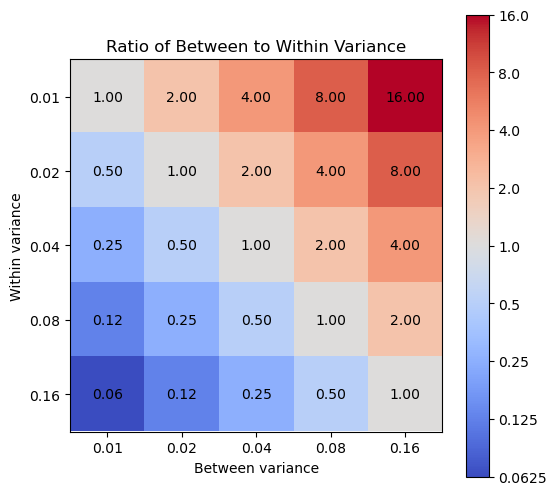

In [45]:
# Define parameters
n_vars = 5
min_between = 0.01

# Generate between and within variance arrays
between_vars = np.array([min_between * (2 ** ii) for ii in range(n_vars)])
within_vars = np.array([min_between * (2 ** ii) for ii in range(n_vars)])

# Initialize matrices
btw = np.full((n_vars, n_vars), np.nan)
within = np.full((n_vars, n_vars), np.nan)
ratio_btwVwithin = np.full((n_vars, n_vars), np.nan)

# Compute matrices
for ii in range(n_vars):
    for jj in range(n_vars):
        btw[ii, jj] = between_vars[jj]
        within[ii, jj] = within_vars[ii]
        ratio_btwVwithin[ii, jj] = between_vars[jj] / within_vars[ii]
        
ratio_plot_labels = def_plot_labels(title = 'Ratio of Between to Within Variance', 
                                    x_label = 'Between variance', y_label = 'Within variance')

plot_matrix(ratio_btwVwithin, ratio_plot_labels, n_vars, between_vars, within_vars)

In [36]:
crowding_param = def_variable_parameters(betweenVar=0.022, withinVar=0.012, mean=-0.426,learning_factor=0.06)
rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
results_corr_df = run_simulation(crowding_param, rsvp_param, range_samples=[320], range_measurements=[2])
a = results_corr_df['rmse_corrected'].iloc[0]
a = results_corr_df['rmse_measured'].iloc[0]

print(a)

0.10486774916945216


In [38]:
# repeat the simulation, change the between and within variances of crowding
# RSVP parameters are kept the same
rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)

rmse_measured_mtx = np.full((n_vars, n_vars), np.nan)
rmse_corrected_mtx = np.full((n_vars, n_vars), np.nan)

for ii in range(n_vars):
    for jj in range(n_vars):
        between_var = between_vars[jj]
        within_var = within_vars[ii]
        crowding_param = def_variable_parameters(betweenVar=between_var, withinVar=within_var,
                                                 mean=-0.426,learning_factor=0.06)
        
        results_corr_df = run_simulation(crowding_param, rsvp_param, range_samples=[320], range_measurements=[2])
        
        rmse_measured_mtx[ii, jj] = results_corr_df['rmse_measured'].iloc[0]
        rmse_corrected_mtx[ii, jj] = results_corr_df['rmse_corrected'].iloc[0]


done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320


[[0.13205204 0.10390927 0.08682482 0.07791996 0.07374622]
 [0.17733175 0.13249352 0.10320036 0.08757684 0.0795309 ]
 [0.22702327 0.17315162 0.13322593 0.10153723 0.08706371]
 [0.27931064 0.22512879 0.1764607  0.13235637 0.10523566]
 [0.32120143 0.2770814  0.22666537 0.17378979 0.13306089]]


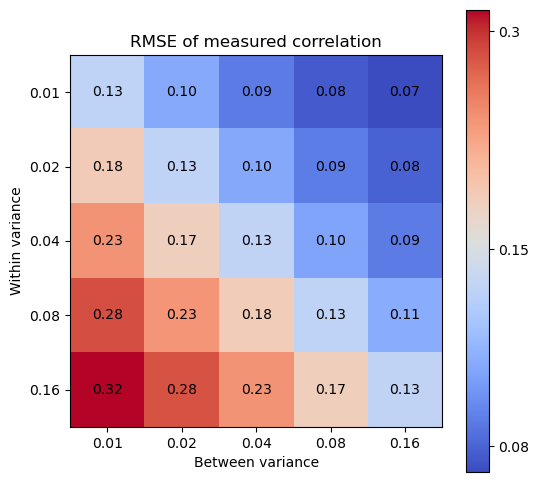

In [57]:
ratio_plot_labels = def_plot_labels(title = 'RMSE of measured correlation', 
                                    x_label = 'Between variance', y_label = 'Within variance')

plot_matrix(rmse_measured_mtx, ratio_plot_labels, n_vars, between_vars, within_vars)

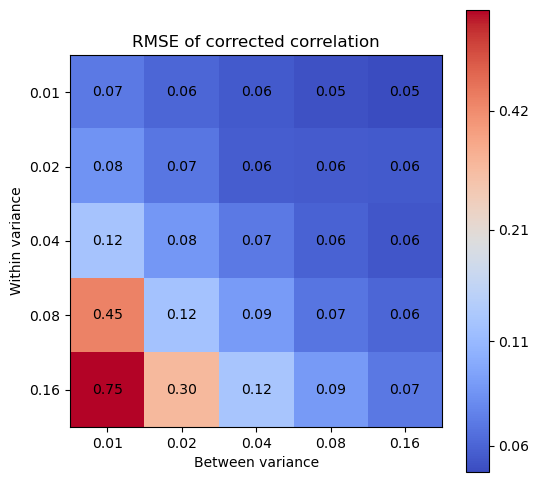

In [58]:
ratio_plot_labels = def_plot_labels(title = 'RMSE of corrected correlation', 
                                    x_label = 'Between variance', y_label = 'Within variance')

plot_matrix(rmse_corrected_mtx, ratio_plot_labels, n_vars, between_vars, within_vars)